# preparation

In [ ]:
!pip install bing-image-downloader

In [ ]:
!mkdir Dataset

In [ ]:
from bing_image_downloader import downloader as dl

nd = ["Gambar Banjir","Gambar Gempa Bumi","Gambar Tsunami","Gambar tanah longsor"]
dl.download(nd[0],limit=500,output_dir='Dataset')
dl.download(nd[1],limit=500,output_dir='Dataset')
dl.download(nd[2],limit=500,output_dir='Dataset')
dl.download(nd[3],limit=500,output_dir='Dataset')

In [ ]:
dl.download(nd[1],limit=1000,output_dir='Dataset')


In [ ]:
dl.download(nd[2],limit=1000,output_dir='Dataset')


In [ ]:
dl.download(nd[3],limit=1000,output_dir='Dataset')


# Model Building

## lib

In [ ]:
# common lib
import os , shutil
import zipfile
import random
import pathlib
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from shutil import copyfile
from pathlib import Path
from tqdm.notebook import tqdm as tq
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.colab import files

# image lib
import cv2
import skimage
from PIL import Image
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# model creation
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model


## starting

### load data

In [ ]:
!pip install opendatasets

{"username":"ftthalmhdi","key":"4906f274376c45215b237ff7a4f7ec0e"}

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/ftthalmhdi/naturaldisaster")

## data preprocessing

In [4]:
image_path = '/content/naturaldisaster/images'
print(os.listdir(image_path))

['BANJIR', 'TSUNAMI', 'GEMPABUMI', 'TANAHLONGSOR']


In [6]:
# beri label pada masing masing file gambar
path = "naturaldisaster/images"
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        print(f"Memproses folder: {class_name}")

        for filename in os.listdir(class_path):
            if filename.endswith(('.jpg', '.png', '.jpeg','.JPG')):  # Filter file gambar

                old_path = os.path.join(class_path, filename)

                new_filename = f"{class_name}_{filename}"  # Misal: WithoutMask_1010101.jpg
                new_path = os.path.join(class_path, new_filename)

                # Rename file
                try:
                    os.rename(old_path, new_path)
                    print(f"Renamed: {filename} -> {new_filename}")
                except Exception as e:
                    print(f"Gagal rename {filename}: {e}")

print("Proses rename selesai!")

Memproses folder: BANJIR
Renamed: Image_101.jpg -> BANJIR_Image_101.jpg
Renamed: Image_318.jpg -> BANJIR_Image_318.jpg
Renamed: Image_311.jpg -> BANJIR_Image_311.jpg
Renamed: Image_3.jpg -> BANJIR_Image_3.jpg
Renamed: Image_329.png -> BANJIR_Image_329.png
Renamed: Image_91.jpg -> BANJIR_Image_91.jpg
Renamed: Image_75.jpg -> BANJIR_Image_75.jpg
Renamed: Image_50.jpg -> BANJIR_Image_50.jpg
Renamed: Image_144.jpg -> BANJIR_Image_144.jpg
Renamed: Image_20.jpg -> BANJIR_Image_20.jpg
Renamed: Image_39.jpg -> BANJIR_Image_39.jpg
Renamed: Image_183.jpg -> BANJIR_Image_183.jpg
Renamed: Image_110.jpg -> BANJIR_Image_110.jpg
Renamed: Image_285.jpg -> BANJIR_Image_285.jpg
Renamed: Image_5.jpg -> BANJIR_Image_5.jpg
Renamed: Image_68.jpg -> BANJIR_Image_68.jpg
Renamed: Image_125.jpg -> BANJIR_Image_125.jpg
Renamed: Image_263.jpeg -> BANJIR_Image_263.jpeg
Renamed: Image_6.jpg -> BANJIR_Image_6.jpg
Renamed: Image_43.jpg -> BANJIR_Image_43.jpg
Renamed: Image_18.jpg -> BANJIR_Image_18.jpg
Renamed: Image

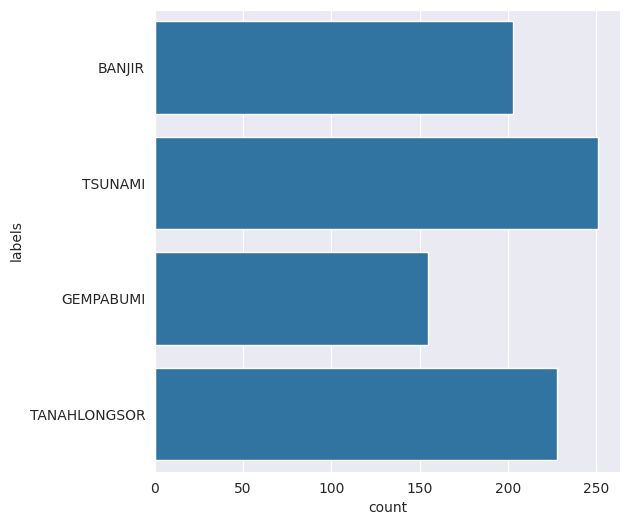

In [7]:
ND_path = "naturaldisaster/images"
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(ND_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [8]:
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [9]:
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

#### BANJIR_aug

In [15]:
images_path = "naturaldisaster/images/BANJIR"
augmented_path = "naturaldisaster/images/BANJIR"
images=[]

for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))


images_to_generate=800
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

### gempabumi_aug

In [16]:
images_path = "naturaldisaster/images/GEMPABUMI"
augmented_path = "naturaldisaster/images/GEMPABUMI"
images=[]

for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

images_to_generate=850
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

### TSUNAMI_Aug

In [17]:
images_path = "naturaldisaster/images/TSUNAMI"
augmented_path = "naturaldisaster/images/TSUNAMI"
images=[]

for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

images_to_generate=750
i=1


while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

### TANAHLONGSOR

In [18]:
images_path = "naturaldisaster/images/TANAHLONGSOR"
augmented_path = "naturaldisaster/images/TANAHLONGSOR"
images=[]

for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

images_to_generate=800
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

In [19]:
print(os.listdir("naturaldisaster/images"))

['TSUNAMI_Augmented', 'BANJIR', 'TANAHLONGSOR_augmented', 'TSUNAMI', 'BANJIR_augmented', 'GEMPABUMI', 'GEMPABUMI_augmented', 'TANAHLONGSOR']


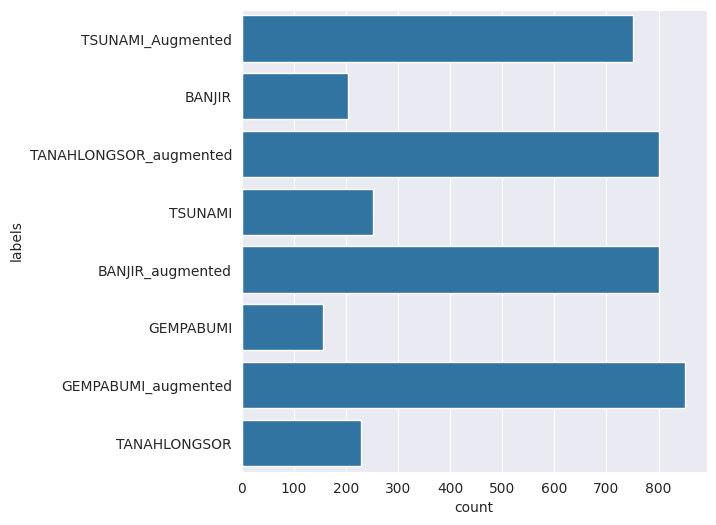

In [20]:
ND_path = "naturaldisaster/images"
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(ND_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)